In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
def relu(z):

    return np.maximum(0, z)


def relu_derivative(z):

    return (z > 0).astype(float)

In [3]:
def sigmoid(z):
    z_clipped = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z_clipped))


def sigmoid_derivative(z):

    s = sigmoid(z)
    return s * (1 - s)

In [4]:
def tanh(z):
    return np.tanh(z)


def tanh_derivative(z):

    t = tanh(z)
    return 1 - t ** 2

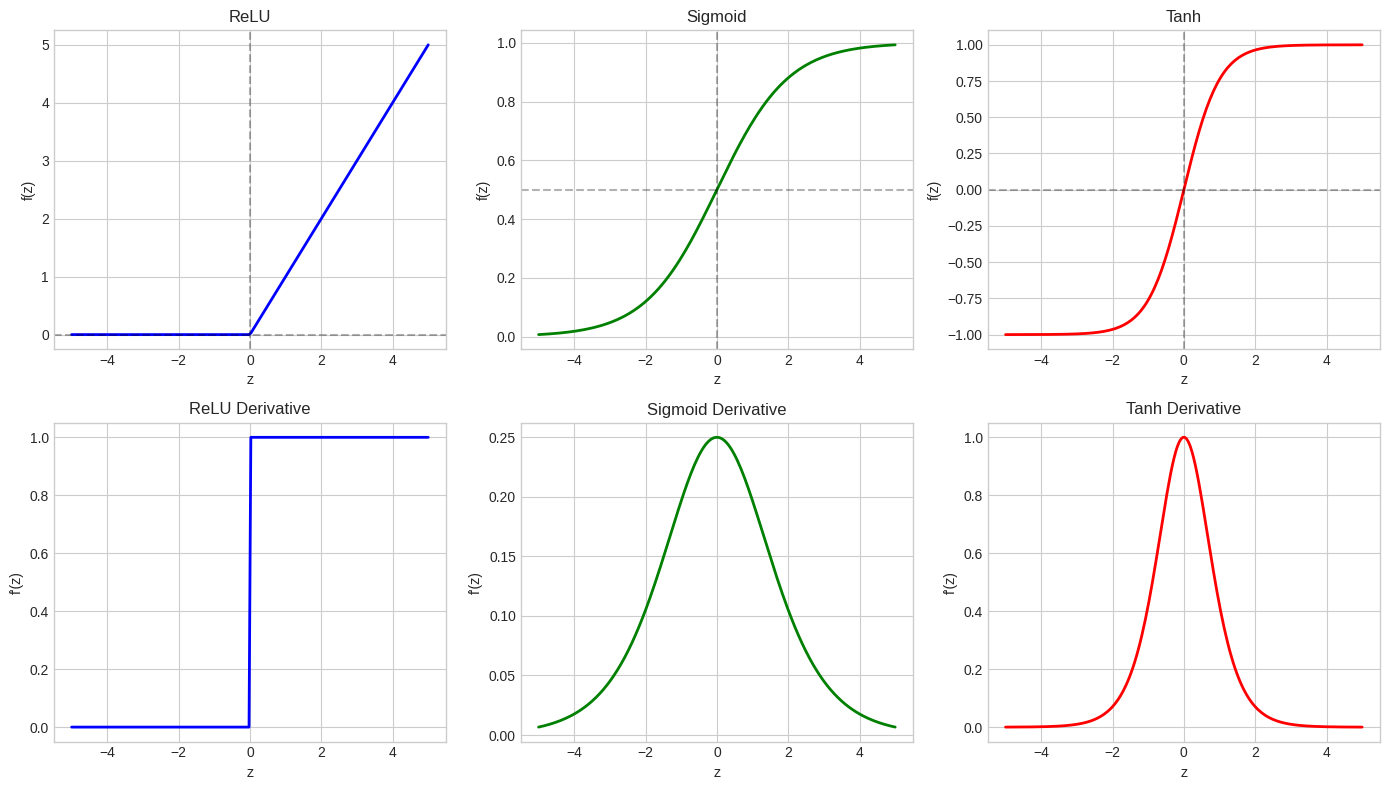

Key Observations:
- ReLU derivative is constant (1) for positive values - no vanishing gradient
- Sigmoid derivative max is 0.25 at z=0 - gradients shrink quickly
- Tanh derivative max is 1.0 at z=0 - better than sigmoid but still vanishes


In [5]:
z_values = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Row 1: Activation functions
axes[0, 0].plot(z_values, relu(z_values), 'b-', linewidth=2)
axes[0, 0].set_title('ReLU')
axes[0, 0].set_xlabel('z')
axes[0, 0].set_ylabel('f(z)')
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].axvline(x=0, color='k', linestyle='--', alpha=0.3)

axes[0, 1].plot(z_values, sigmoid(z_values), 'g-', linewidth=2)
axes[0, 1].set_title('Sigmoid')
axes[0, 1].set_xlabel('z')
axes[0, 1].set_ylabel('f(z)')
axes[0, 1].axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
axes[0, 1].axvline(x=0, color='k', linestyle='--', alpha=0.3)

axes[0, 2].plot(z_values, tanh(z_values), 'r-', linewidth=2)
axes[0, 2].set_title('Tanh')
axes[0, 2].set_xlabel('z')
axes[0, 2].set_ylabel('f(z)')
axes[0, 2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 2].axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Row 2: Derivatives
axes[1, 0].plot(z_values, relu_derivative(z_values), 'b-', linewidth=2)
axes[1, 0].set_title('ReLU Derivative')
axes[1, 0].set_xlabel('z')
axes[1, 0].set_ylabel("f'(z)")

axes[1, 1].plot(z_values, sigmoid_derivative(z_values), 'g-', linewidth=2)
axes[1, 1].set_title('Sigmoid Derivative')
axes[1, 1].set_xlabel('z')
axes[1, 1].set_ylabel("f'(z)")

axes[1, 2].plot(z_values, tanh_derivative(z_values), 'r-', linewidth=2)
axes[1, 2].set_title('Tanh Derivative')
axes[1, 2].set_xlabel('z')
axes[1, 2].set_ylabel("f'(z)")

plt.tight_layout()
plt.show()

print("Key Observations:")
print("- ReLU derivative is constant (1) for positive values - no vanishing gradient")
print("- Sigmoid derivative max is 0.25 at z=0 - gradients shrink quickly")
print("- Tanh derivative max is 1.0 at z=0 - better than sigmoid but still vanishes")

Loss Functions


Mean Squared Error (MSE) - For Regression


Formula:

L = (1/n) * sum((y_true - y_pred)^2)


Derivative w.r.t y_pred:

 dL/dy_pred = (2/n) * (y_pred - y_true)

In [6]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_squared_error_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

Weight Initialization

In [7]:
def initialize_parameters(layer_dimensions, initialization = 'he', seed = 42):
  np.random.seed(seed)
  parameters = {}
  num_layers = len(layer_dimensions)

  for layer_idx in range(1, num_layers):
    n_in = layer_dimensions[layer_idx -1]
    n_out = layer_dimensions[layer_idx]

    if initialization == 'he':
      std = np.sqrt(2 / n_in)
    elif initialization == 'xavier':
      std = np.sqrt(1 / (n_in+n_out))
    else:
      std = 0.01

    parameters[f'W{layer_idx}'] = np.random.randn(n_in, n_out) * std
    parameters[f'b{layer_idx}'] = np.zeros((1, n_out))

  return parameters

forword propagation


The Math


For each layer l:

  Linear transformation:

    Z[l] = A[l-1] @ W[l] + b[l]


Activation:

    A[l] = activation(Z[l])

We store Z and A values because backpropagation needs them to compute gradients.

In [8]:
def forward_propagation(X, parameters, activation = 'relu'):

  num_layers = len(parameters) // 2

  cache = {'A0' : X}
  A_current = X

  for layer_idx in range(1, num_layers):
      w = parameters[f'W{layer_idx}']
      b = parameters[f'b{layer_idx}']

      Z = A_current @ w + b

      if activation == 'relu':
        A = relu(Z)
      elif activation == 'sigmoid':
        A = sigmoid(Z)
      elif activation == 'tanh':
        A = tanh(Z)

      cache[f'Z{layer_idx}'] = Z
      cache[f'A{layer_idx}'] = A
      A_current = A


  W_out = parameters[f'W{num_layers}']
  b_out = parameters[f'b{num_layers}']
  Z_out = A_current @ W_out + b_out
  y_pred = Z_out

  cache[f'Z{num_layers}'] = Z_out
  cache[f'A{num_layers}'] = y_pred
  return y_pred, cache

 Backpropagation


The Chain Rule


To update W[l], we need dL/dW[l].



By chain rule:



    dL/dW[l] = dL/dZ[l] * dZ[l]/dW[l]
         = dZ[l] * A[l-1].T
And for the next layer back:


    dL/dA[l-1] = W[l].T @ dZ[l]
    dL/dZ[l-1] = dL/dA[l-1] * activation_derivative(Z[l-1])



1.  Use dZ to compute dW and db


2. Compute dA_prev to pass to the previous layer



3. Apply activation derivative to get dZ for previous layer



In [9]:
def backward_propagation(parameters, cache, y_true, activation = 'relu'):
  gradients = {}

  num_layers = len(parameters) // 2
  n_samples = y_true.shape[0]

  y_pred = cache[f'A{num_layers}']

  # dL/dZ_out = dL/dy_pred
  # For MSE: dL/dy_pred = (2/n) * (y_pred - y_true)
  dZ_current = (2 / n_samples) * (y_pred - y_true)

  A_prev = cache[f'A{num_layers - 1}']
  gradients[f'dW{num_layers}'] = A_prev.T @ dZ_current
  gradients[f'db{num_layers}'] = np.sum(dZ_current, axis=0, keepdims=True)

  dA_prev = dZ_current @ parameters[f'W{num_layers}'].T

  for layer_idx in reversed(range(1, num_layers)):

    Z_current = cache[f'Z{layer_idx}']
    A_prev = cache[f'A{layer_idx - 1}']

    if activation == 'relu':
      dZ_current = dA_prev * relu_derivative(Z_current)
    elif activation == 'sigmoid':
      dZ_current = dA_prev * sigmoid_derivative(Z_current)
    elif activation == 'tanh':
      dZ_current = dA_prev * tanh_derivative(Z_current)


    gradients[f'dW{layer_idx}'] = A_prev.T @ dZ_current
    gradients[f'db{layer_idx}'] = np.sum(dZ_current, axis=0, keepdims=True)

    if layer_idx > 1:
      dA_prev = dZ_current @ parameters[f'W{layer_idx}'].T

  return gradients

Parameter Update (Gradient Descent)

In [10]:
def update_parameters(parameters, gradients, learning_rate):
  num_layers = len(parameters) // 2
  for layer_idx in range(1, num_layers + 1):
    parameters[f'W{layer_idx}'] -= learning_rate * gradients[f'dW{layer_idx}']
    parameters[f'b{layer_idx}'] -= learning_rate * gradients[f'db{layer_idx}']

  return parameters

The Training Loop


for each epoch:


    1. Forward pass: compute predictions
    2. Compute loss
    3. Backward pass: compute gradients
    4. Update parameters

In [11]:
def train_network(X_train, y_train, layer_dimensions,
                  learning_rate=0.01, num_epochs=1000,
                  activation='relu', initialization='he',
                  print_every=200, seed=42):
      # Initialize parameters
    parameters = initialize_parameters(layer_dimensions, initialization, seed)
    loss_history = []

    print(f"Training network: {layer_dimensions}")
    print(f"Activation: {activation}, LR: {learning_rate}, Epochs: {num_epochs}")
    print("-" * 50)
    for epoch in range(num_epochs):
        # Forward propagation
        y_pred, cache = forward_propagation(X_train, parameters, activation)

        # Compute loss
        loss = mean_squared_error(y_train, y_pred)
        loss_history.append(loss)

        # Backward propagation
        gradients = backward_propagation(parameters, cache, y_train, activation)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch + 1:5d} | Loss: {loss:.6f}")

    print("-" * 50)
    print(f"Final Loss: {loss_history[-1]:.6f}")

    return parameters, loss_history


creating datasets for Experiments

1. Sinusoidal:

    Non-linear, periodic - tests non-linear function approximation


2. Linear:

    Simple relationship - network should easily fit


3. Polynomial:

    Non-linear, non-periodic - tests smooth curve fitting


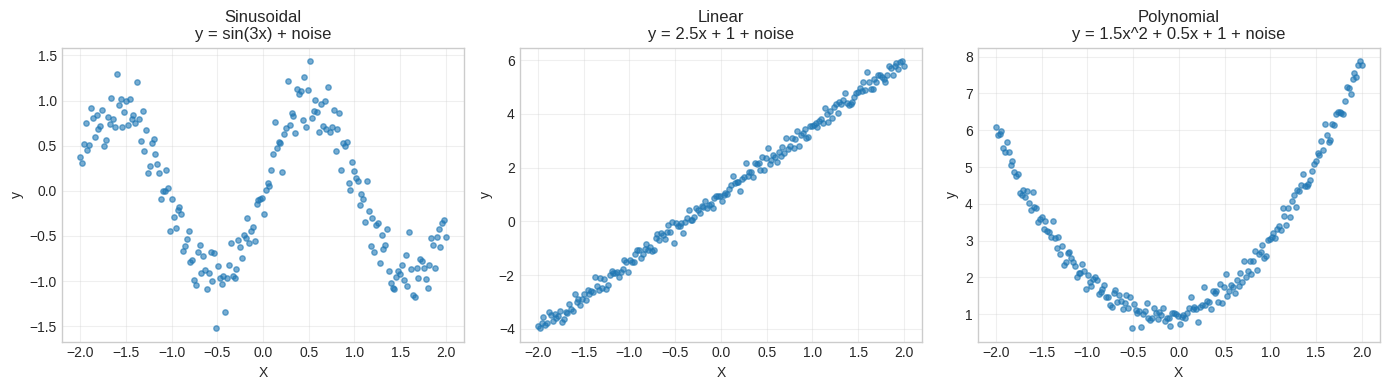

In [12]:
# with help of ai

def generate_datasets(n_samples=200, noise_level=0.2, seed=42):
    np.random.seed(seed)
    X = np.linspace(-2, 2, n_samples).reshape(-1, 1)
    noise = noise_level * np.random.randn(n_samples, 1)

    datasets = {
        'sinusoidal': {
            'X': X,
            'y': np.sin(3 * X) + noise,
            'description': 'y = sin(3x) + noise'
        },
        'linear': {
            'X': X,
            'y': 2.5 * X + 1.0 + noise,
            'description': 'y = 2.5x + 1 + noise'
        },
        'polynomial': {
            'X': X,
            'y': 1.5 * X**2 + 0.5 * X + 1.0 + noise,
            'description': 'y = 1.5x^2 + 0.5x + 1 + noise'
        }
    }

    return datasets



datasets = generate_datasets()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (name, data) in enumerate(datasets.items()):
    axes[idx].scatter(data['X'], data['y'], alpha=0.6, s=15)
    axes[idx].set_title(f"{name.capitalize()}\n{data['description']}")
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('y')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

train all datasets

In [13]:

NETWORK_ARCHITECTURE = [1, 10, 10, 1]  # Input -> Hidden -> Hidden -> Output
LEARNING_RATE = 0.1
NUM_EPOCHS = 3000
ACTIVATION = 'relu'


results = {}

for name, data in datasets.items():
    print(f"\n{'='*60}")
    print(f"Training on {name.upper()} data")
    print(f"{'='*60}")

    trained_params, loss_history = train_network(
        X_train=data['X'],
        y_train = data['y'].reshape(-1, 1),
        layer_dimensions=NETWORK_ARCHITECTURE,
        learning_rate=LEARNING_RATE,
        num_epochs=NUM_EPOCHS,
        activation=ACTIVATION,
        print_every=500
    )

    results[name] = {
        'parameters': trained_params,
        'loss_history': loss_history
    }


Training on SINUSOIDAL data
Training network: [1, 10, 10, 1]
Activation: relu, LR: 0.1, Epochs: 3000
--------------------------------------------------
Epoch     1 | Loss: 0.582969
Epoch   500 | Loss: 0.090805
Epoch  1000 | Loss: 0.079488
Epoch  1500 | Loss: 0.077541
Epoch  2000 | Loss: 0.075191
Epoch  2500 | Loss: 0.072200
Epoch  3000 | Loss: 0.074004
--------------------------------------------------
Final Loss: 0.074004

Training on LINEAR data
Training network: [1, 10, 10, 1]
Activation: relu, LR: 0.1, Epochs: 3000
--------------------------------------------------
Epoch     1 | Loss: 10.031647
Epoch   500 | Loss: 0.594486
Epoch  1000 | Loss: 0.436695
Epoch  1500 | Loss: 0.373390
Epoch  2000 | Loss: 0.324476
Epoch  2500 | Loss: 0.272660
Epoch  3000 | Loss: 0.225428
--------------------------------------------------
Final Loss: 0.225428

Training on POLYNOMIAL data
Training network: [1, 10, 10, 1]
Activation: relu, LR: 0.1, Epochs: 3000
---------------------------------------------

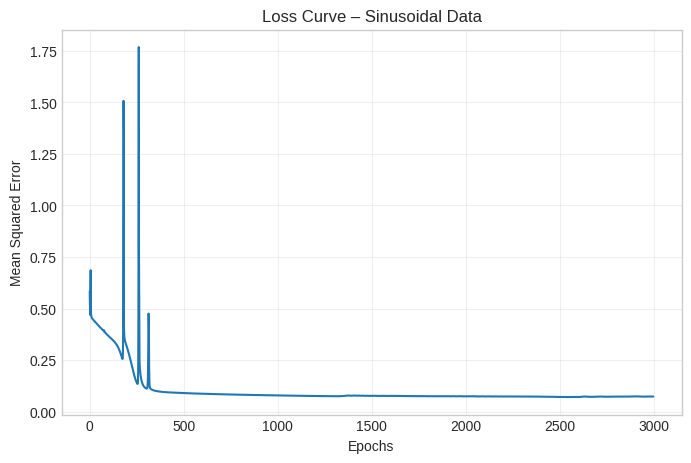

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(results['sinusoidal']['loss_history'])
plt.title("Loss Curve – Sinusoidal Data")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid(True, alpha=0.3)
plt.show()

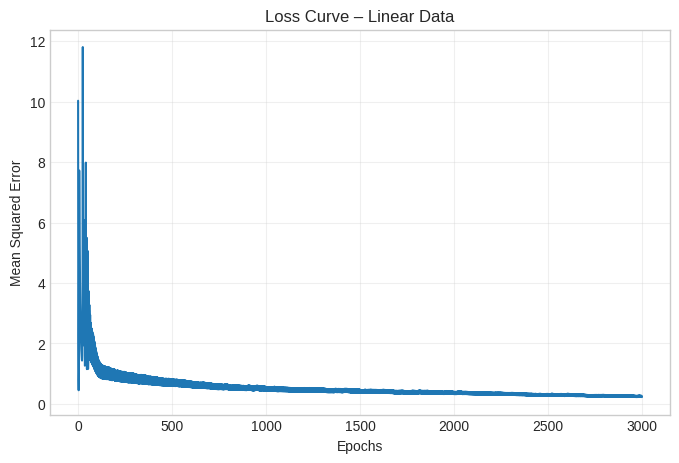

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(results['linear']['loss_history'])
plt.title("Loss Curve – Linear Data")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid(True, alpha=0.3)
plt.show()


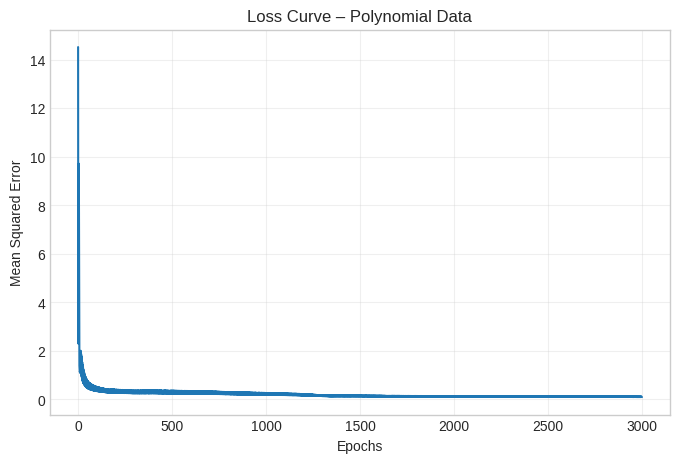

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(results['polynomial']['loss_history'])
plt.title("Loss Curve – Polynomial Data")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid(True, alpha=0.3)
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

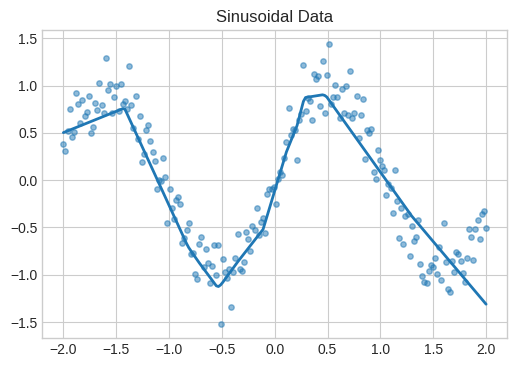

In [17]:
name = 'sinusoidal'
data = datasets[name]

X = data['X']
y_true = data['y']
params = results[name]['parameters']

y_pred, _ = forward_propagation(X, params, activation=ACTIVATION)

sort_idx = np.argsort(X[:, 0])
X_sorted = X[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(6, 4))
plt.scatter(X, y_true, alpha=0.5, s=15, label='True Data')
plt.plot(X_sorted, y_pred_sorted, linewidth=2, label='Prediction')
plt.title("Sinusoidal Data")
plt


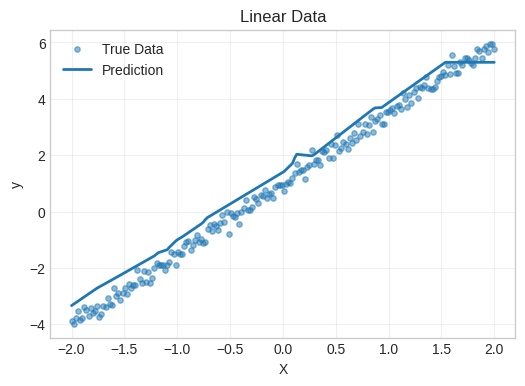

In [18]:
name = 'linear'
data = datasets[name]

X = data['X']
y_true = data['y']
params = results[name]['parameters']

y_pred, _ = forward_propagation(X, params, activation=ACTIVATION)

sort_idx = np.argsort(X[:, 0])
X_sorted = X[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(6, 4))
plt.scatter(X, y_true, alpha=0.5, s=15, label='True Data')
plt.plot(X_sorted, y_pred_sorted, linewidth=2, label='Prediction')
plt.title("Linear Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


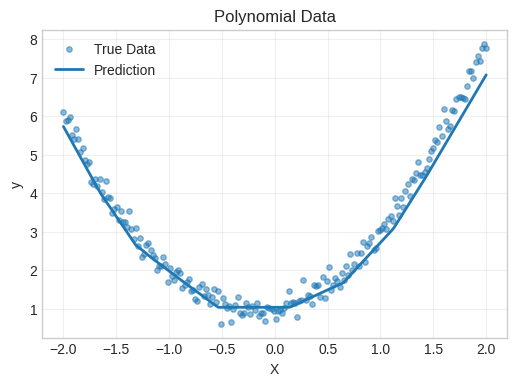

In [19]:
name = 'polynomial'
data = datasets[name]

X = data['X']
y_true = data['y']
params = results[name]['parameters']

y_pred, _ = forward_propagation(X, params, activation=ACTIVATION)

sort_idx = np.argsort(X[:, 0])
X_sorted = X[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(6, 4))
plt.scatter(X, y_true, alpha=0.5, s=15, label='True Data')
plt.plot(X_sorted, y_pred_sorted, linewidth=2, label='Prediction')
plt.title("Polynomial Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
